In [1]:
import Pkg; Pkg.add(["Plots","Interact"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = true;

In [3]:
using LinearAlgebra;
using Plots; plotlyjs(); default(l=5, size=(900,550), label=false);
using Printf;
using Interact;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
    macro manipulate(v)
        return :($v; plot!())
    end
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

WebIO._IJuliaInit()

# Rayleigh Quotient & Inverse Iteration

## Review

### Our Stable Eigenvalue-revealing Factorization: Schur Decomposition

$$\large A = Q T Q^*, \quad Q^{-1} = Q^*, \quad T = \mathrm{triu}(T).$$

### Iteratively computed

We compute a Schur factorization $A = QTQ^*$ by transforming $A$ by a sequence of elementary unitary similarity transformations $X \mapsto Q_j^* X Q_j$.  We want

$$
\underbrace{Q_j^* \cdots Q_1^* Q_0^*}_{Q^*} A \underbrace{Q_0 Q_1 \cdots Q_j}_{Q}
$$

to converge rapidly to an upper triangular matrix $T$ as $j \to \infty$.

### Two Phases: $A$ is nonhermitian

$$
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\end{bmatrix}}_{A}
\quad
\stackrel{\text{Phase 1: } Q_0}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
& \times & \times & \times & \times \\
& & \times & \times & \times \\
& & & \times & \times \\
\end{bmatrix}}_{H}
\quad
\stackrel{\text{Phase 2: } Q_1 \cdot Q_{j \to \infty}}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
& \times & \times & \times & \times \\
& & \times & \times & \times \\
& & & \times & \times \\
& & & & \times \\
\end{bmatrix}}_{T}
$$

- Phase 1: $\sim \frac{10}{3} m^3$ operations
- Phase 2: $O(m^2)$ operations **per iteration** ($O(m^3)$ if we did not do phase 1)

### Two Phases: $A$ hermitian

$$
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\end{bmatrix}}_{A}
\quad
\stackrel{\text{Phase 1: } Q_0}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times & \times & & & \\
\times & \times & \times & & \\
& \times & \times & \times & \\
& & \times & \times & \times \\
& & & \times & \times \\
\end{bmatrix}}_{T}
\quad
\stackrel{\text{Phase 2: } Q_1 \cdots Q_{j\to\infty}}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times &  &  &  & \\
& \times & & & \\
& & \times & & \\
& & & \times & \\
& & & & \times \\
\end{bmatrix}}_{D}
$$

- Phase 1: $\sim \frac{4}{3}m^3$ operations
- Phase 2: $O(m)$ operations **per iteration**

### Today: $A$ real & symmetric, $\|\cdot\| = \|\cdot\|_2$

- Real & symmetric $\subset$ hermitian $\subset$ normal $\Rightarrow$

1. Diagonalizable, $A = X \Lambda X^{-1}$

2. Unitarily diagonalizable, $A = Q \Lambda Q^T, \quad Q^T = Q^{-1}$

- $\lambda_1, \dots, \lambda_m$ are the eigenvalues of $A$

- Columns of $Q = [q_1 | \cdots | q_m]$ are an orthonormal eigenbasis of $A$

## Rayleigh Quotients

The _Rayleigh quotient_ of a vector $x \in \mathbb{R}^m$ is the scalar

$$\Large r(x) = \frac{x^T A x}{x^T x}.$$

What does it mean?

### Rayleigh Quotient of an eigenvector

$$\Large r(q_k) =  \frac{q_k^T A q_k}{q_k^T q_k} = \frac{q_k^T q_k \lambda_k}{q_k^T q_k} = \lambda_k$$

### General $x$: "What scalar $\alpha$ acts most like an eigenvalue of $x$?"

$$\arg\min_\alpha \|Ax - \alpha x\|$$

$$ = \arg\min_\alpha \frac{1}{2} \|Ax - \alpha x\|^2$$
$$= \arg\min_\alpha \frac{1}{2}(Ax - \alpha x)^T(Ax - \alpha x)$$

$$ = {\arg\min_\alpha} \left\{ \frac{1}{2} (Ax)^T Ax - \frac{1}{2} (Ax)^T \alpha x - \frac{1}{2} \alpha x^T (Ax) + \frac{1}{2} \alpha^2 x^T x\right\}$$

$$ = \arg\min_\alpha \frac{1}{2} x^T A^2 x - \alpha x^T Ax + \frac{1}{2} \alpha^2 x^T x$$

$\Leftrightarrow$ gradient w.r.t. $\alpha$ is 0: $\quad\quad- x^T A x + \alpha x^T x = 0,\quad\quad$ which is the same as $\alpha = r(x).$

So if $A$ is symmetric and real, and we have a current approximation $x^{(k)}$ of an eigenvector,

$$\Large r(x^{(k)}) = \frac{x^{(k)T} A x^{(k)}}{x^{(k)T} x^{(k)}}$$

is a good approximation of its eigenvalue.

### The gradient of $r(x)$ w.r.t. $x$

$$\nabla r(x) = \frac{\nabla \{x^T A x\}}{x^T x} - \frac{x^T A x}{(x^T x)^2}\nabla\{x^Tx\}$$

$$= \frac{(A + A^T)x}{x^T x} - \frac{x^T A x}{x^T x}\frac{2x}{x^T x}$$

$$= \frac{2(A - r(x)I)x}{x^T x}$$

$$\nabla r(x) = \frac{2(A - r(x)I)x}{x^T x}$$

$$\nabla r(x) = 0 \quad \Leftrightarrow \quad (A - r(x) I) x = 0 \quad \Leftrightarrow \quad A x = r(x) I$$

**Stationary points** of $r$ are eigenvectors of $A$

### Example: $A \in \mathbb{R}^{3 \times 3}$

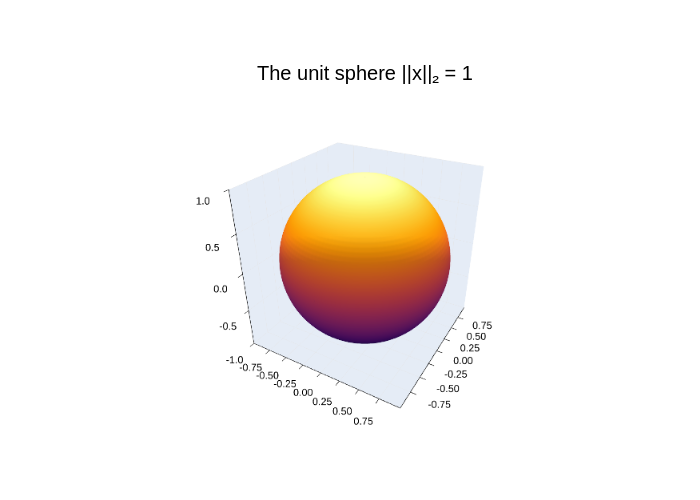

In [4]:
N = 128
θ = LinRange(0,2π,N)
ϕ = LinRange(-π/2,π/2,div(N,2))

x = cos.(θ) * cos.(ϕ)'
y = sin.(θ) * cos.(ϕ)'
z = ones(length(θ)) * sin.(ϕ)'
surface(x,y,z,title="The unit sphere ||x||₂ = 1",legend=false)

In [5]:
A = randn(3,3); A = (1/2) * (A + A')
Λ, Q = eigen(A);

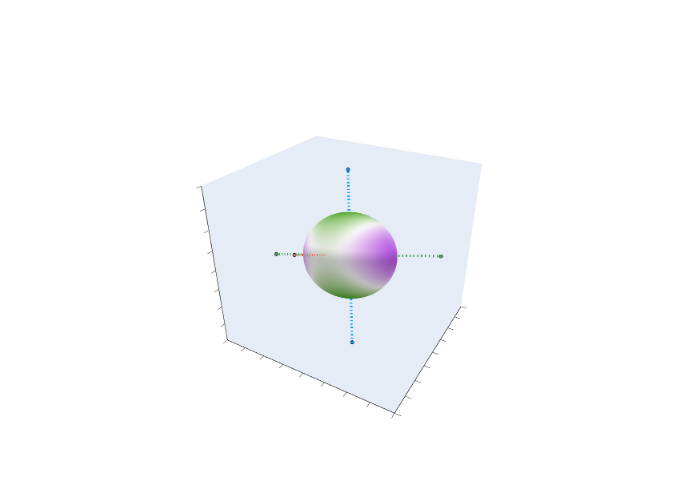

In [6]:
xyz = [reshape(copy(x), length(x)) reshape(copy(y), length(y)) reshape(copy(z), length(z))]'
r = [xyz[:,i]' * A * xyz[:,i] for i in 1:size(xyz)[2]]
c = reshape(r, (N, div(N,2)))
thisplot = surface(x,y,z,sc=c,legend=false,ticks=false, c=:diverging_gwv_55_95_c39_n256, lim=(-2,2))
for j in 1:3
    plot!(thisplot,2 .* Q[1,j] .* [-1,1],  2 .* Q[2,j] .* [-1,1], 2 .* Q[3,j] .* [-1,1], m=(1,:o), c=j, l=:dash)
end
plot!(thisplot, size=(1300,800))

### Consequence of zero gradient: quadratic accuracy

For fixed eigenvector $q_J$, using the Taylor expansion

$$r(x) = r(q_J) + \underbrace{\nabla r(q_J)}_{0}^T (x - q_J) + O(\|x - q_J\|^2)$$

$$\Rightarrow r(x) - r(q_J) = O(\|x - q_J\|^2) \quad \text{as }x \to q_J$$

$r(x)$ is an estimate of $r(q_J) = \lambda_J$ that improves _quadratically_ as $x \to q_J$

## Rates of convergence

### Recall: power iteration

In [7]:
function power_iteration(A, v⁰ = randn(size(A)[1]), n_iter = size(A)[1])
    v = copy(v⁰) / norm(v⁰)
    Av = A * v
    λ = one(eltype(A))
    for k in 1:n_iter
        v = Av / norm(Av)
        Av = A * v  # ← a tridiagonal matvec is O(m) work
        λ = v' * Av # ← Rayleigh quotient (because v' * v = 1)
    end
    return (λ, v)
end

power_iteration (generic function with 3 methods)

### `power_iteration` applied to random matrices

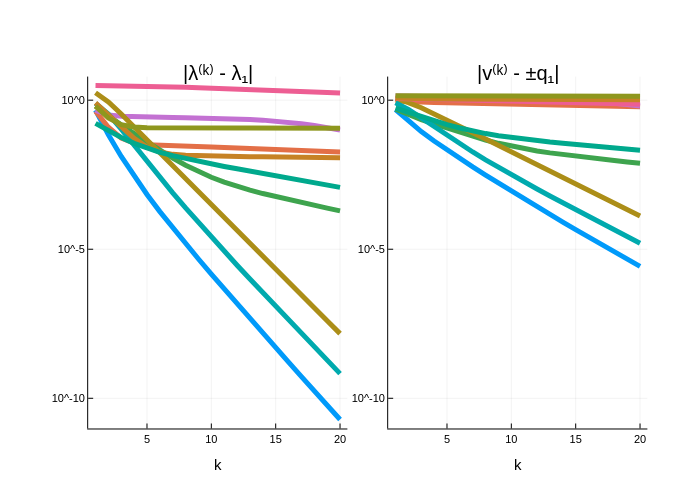

In [8]:
p = plot(xlabel="k", title="|λ⁽ᵏ⁾ - λ₁|", yscale=:log10)
q = plot(xlabel="k", title="|v⁽ᵏ⁾ - ±q₁|", yscale=:log10)
m = 10
n_iter = 20
n_test = 10
minval = 1
maxval = 1
for test in 1:n_test
    Λ = randn(m)
    Q = qr(randn(m,m)).Q
    A = Q * Diagonal(Λ) * Q'
    v⁰ = randn(m);
    jmax = argmax(abs.(Λ))
    data = [power_iteration(A, v⁰, i) for i in 1:n_iter]
    λs = [data[i][1] for i in 1:n_iter]
    errs = [min(norm(data[i][2] - Q[:,jmax]), norm(data[i][2] + Q[:,jmax])) for i in 1:n_iter]
    minval = min(minval, minimum(abs.(λs .- Λ[jmax])), minimum(errs))
    maxval = max(maxval, maximum(abs.(λs .- Λ[jmax])), maximum(errs))
    plot!(p, 1:n_iter, max.(eps(), abs.(λs .- Λ[jmax])))
    plot!(q, 1:n_iter, max.(eps(), errs))
end
minval = max(minval, eps())
plot(p, q, layout=(1,2), ylim=(0.5*minval, 2.0*maxval))

- All convergence plots seem to converge to straight lines on linear-log plots
- Eigenvalues estimates appear to converge faster that eigenvector estimates

- We said the convergence of this approach is "slow": how slow is slow?

Suppose eigenvalues are ordered by magnitude, $|\lambda_1| \geq |\lambda_2| \geq \cdots \geq |\lambda_m|$, and

$$v^{(0)} = a_1 q_1 + a_2 q_2 + \cdots + a_m q_m.$$

$$v^{(k)} = \underbrace{c_k}_{\text{from normalization}} A^k v^{(0)}$$

$$ = c_k \sum_{j=1}^m A^k a_j q_j$$

$$ = c_k \sum_{j=1}^m \lambda_j^k a_j q_j$$

$$ = c_k \lambda_1^k \sum_{j=1}^m \big(\underbrace{\frac{\lambda_j}{\lambda_1}}_{|\cdot|\leq 1}\big)^k a_j q_j$$

### T&B Theorem 27.1.

Suppose $|\lambda_1| > |\lambda_2| \geq \cdots \geq |\lambda_m|$ and $a_1 = q_1^T v^{(0)} \neq 0$.  Then for `power_iteration`,

$$\|v^{(k)} - (\pm q_1)\| = O\left(\left|\frac{\lambda_2}{\lambda_1}\right|^k\right),
\quad
|\lambda^{(k)} - \lambda_1| = O\left(\left|\frac{\lambda_2}{\lambda_1}\right|^{2k}\right).$$

- $\log\|v^{(k)} - (\pm q_1)\| = O(k\log|\lambda_2 / \lambda_1|)$.  This is **linear convergence** with **convergence factor** $|\lambda_2 / \lambda_1|$.

- $\log|\lambda^{(k)} - \lambda_1| = O(k\log(|\lambda_2 / \lambda_1|^2))$. This is _also_ linear convergence, but with convergence factor $|\lambda_2 / \lambda_1|^2$.

- The separation $|\lambda_2 / \lambda_1|$ affects the convergence factor.

## Inverse Iteration

### Basic idea

- Eigenvectors of $A$ are eigenvectors of $A - \mu I$ for any $\mu$,

$$A - \mu I = Q (\Lambda - \mu I)  Q^*$$
  

- If $\mu$ is not an eigenvalue of $A$, eigenvectors of $A$ are eigenvectors of $(A - \mu I)^{-1}$,

$$(A - \mu I)^{-1} = Q (\Lambda - \mu I)^{-1}  Q^*$$

- Even if $|\lambda_2  / \lambda_1|$ is large (close to 1), we can choose $\mu$ so that

$$\large\left|\frac{\lambda_1 - \mu}{\lambda_2 - \mu}\right|$$

is small.

In [9]:
m = 10; Λ = sort(rand(m), rev=true); Λ[1:2]

2-element Vector{Float64}:
 0.9487446603260669
 0.8113355361604171

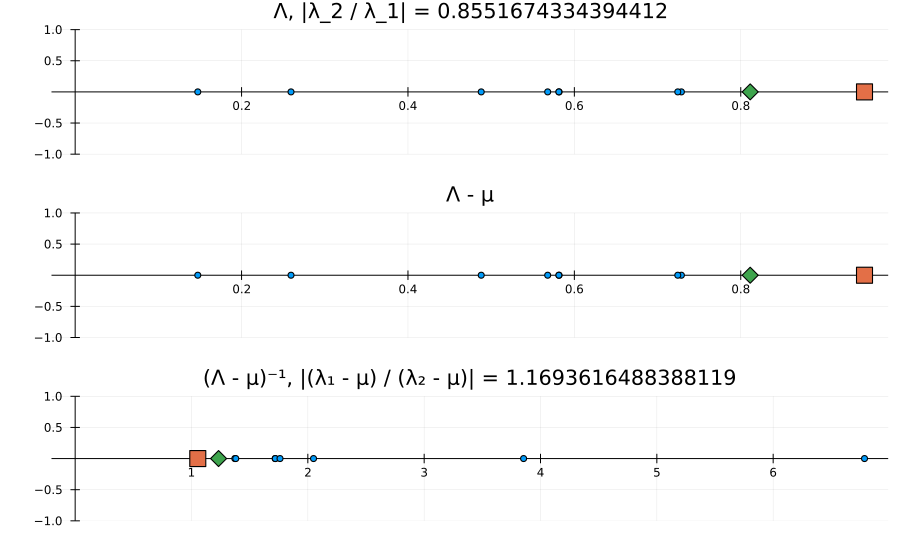

In [10]:
gr();
@manipulate for μ = 0.0
    p = plot(Λ, st=:scatter, ylim=(-1,1), framestyle=:origin, zeros(m), fmt=:png, title = "Λ, |λ_2 / λ_1| = $(Λ[2] / Λ[1])")
    plot!(p, Λ[[1]], [0], st=:scatter, m=(8,:square))
    plot!(p, Λ[[2]], [0], st=:scatter, m=(8,:diamond))
    q = plot(Λ .- μ, st=:scatter, ylim=(-1,1), framestyle=:origin, zeros(m), fmt=:png, title = "Λ - μ")
    plot!(q, (Λ .- μ)[[1]], [0], st=:scatter, m=(8,:square))
    plot!(q, (Λ .- μ)[[2]], [0], st=:scatter, m=(8,:diamond))
    r = plot(1 ./ (Λ .- μ), st=:scatter, ylim=(-1,1), framestyle=:origin, zeros(m), fmt=:png, title = "(Λ - μ)⁻¹, |(λ₁ - μ) / (λ₂ - μ)| = $(abs((Λ[1]-μ)/(Λ[2]-μ)))")
    plot!(r, 1/(Λ .- μ)[[1]], [0], st=:scatter, m=(8,:square))
    plot!(r, 1/(Λ .- μ)[[2]], [0], st=:scatter, m=(8,:diamond))
    plot(p, q, r, layout=(3,1))
end

In [11]:
function inverse_iteration(A, μ,  v⁰ = randn(size(A)[1]), n_iter = size(A)[1])
    v = copy(v⁰) / norm(v⁰)
    λ = one(eltype(A))
    for k in 1:n_iter
        w = (A - μ * I) \ v # ← A tridiagonal solve is O(m) work
        v = w / norm(w)
        λ = v' * A * v # ← Rayleigh quotient (because v' * v = 1)
    end
    return (λ, v)
end

inverse_iteration (generic function with 3 methods)

### `inverse_iteration` applied to random matrices

Place $\mu = \alpha \lambda_1 + (1 - \alpha) \lambda_2$

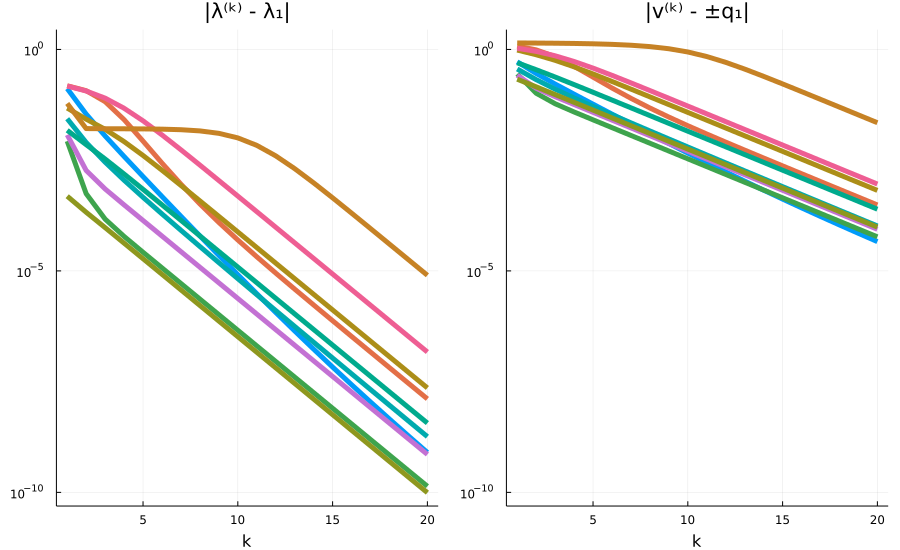

In [12]:
@manipulate for α = 0.6
    p = plot(xlabel="k", title="|λ⁽ᵏ⁾ - λ₁|", yscale=:log10)
    q = plot(xlabel="k", title="|v⁽ᵏ⁾ - ±q₁|", yscale=:log10)
    m = 10
    n_iter = 20
    n_test = 10
    minval = 1
    maxval = 1
    for test in 1:n_test
        Λ = sort(rand(m))
        μ = α * Λ[1] + (1 - α) * Λ[2]
        Q = qr(randn(m,m)).Q
        A = Q * Diagonal(Λ) * Q'
        v⁰ = randn(m);
        jmax = 1
        data = [inverse_iteration(A, μ, v⁰, i) for i in 1:n_iter]
        λs = [data[i][1] for i in 1:n_iter]
        errs = [min(norm(data[i][2] - Q[:,jmax]), norm(data[i][2] + Q[:,jmax])) for i in 1:n_iter]
        minval = min(minval, minimum(abs.(λs .- Λ[jmax])), minimum(errs))
        maxval = max(maxval, maximum(abs.(λs .- Λ[jmax])), maximum(errs))
        plot!(p, 1:n_iter, max.(eps(), abs.(λs .- Λ[jmax])))
        plot!(q, 1:n_iter, max.(eps(), errs))
    end
    minval = max(minval, eps())
    plot(p, q, layout=(1,2), ylim=(0.5*minval, 2.0*maxval))
end

- We can target **any** $\lambda_J$, not just $\lambda_1$

### T&B Theorem 27.2.

Suppose $\lambda_J$ is the closest eigenvalue to $\mu$, $\lambda_K$ is the second closest, and $q_J^T v^{(0)} \neq 0$.  Then for `inverse_iteration`, 

$$\|v^{(k)} - (\pm q_J)\| = O\left(\left|\frac{\lambda_J - \mu}{\lambda_K - \mu}\right|^k\right),
\quad
|\lambda^{(k)} - \lambda_J| = O\left(\left|\frac{\lambda_J - \mu}{\lambda_K - \mu}\right|^{2k}\right).$$

- _If_ we have a good estimate of the eigenvalue we are looking for, we can have **linear convergence** with a good convergence factor, regardless of the separation between $\lambda_J$ and $\lambda_k$.

## Rayleigh Quotient Iteration

1. Use the $r(v)$ to get a good estimate $\mu \approx \lambda_J$
2. Use power iteration with $(A - \mu I)^{-1}$ to get a better estimate of $q_J$
3. Repeat

In [13]:
function rayleigh_quotient_iteration(A, v⁰ = randn(size(A)[1]), n_iter = size(A)[1])
    v = copy(v⁰) / norm(v⁰)
    w = copy(v)
    λ = v' * A * v
    for k in 1:n_iter
        try
            w = (A - λ * I) \ v # Shifted inverse power iteration
        catch e
            if isa(e, SingularException) # Matrix is singular: converged
                return (λ, v)
            else
                throw(e)
            end
        end
        v = w / norm(w)
        λ = v' * A * v # ← Rayleigh quotient (because v' * v = 1)
    end
    return (λ, v)
end

rayleigh_quotient_iteration (generic function with 3 methods)

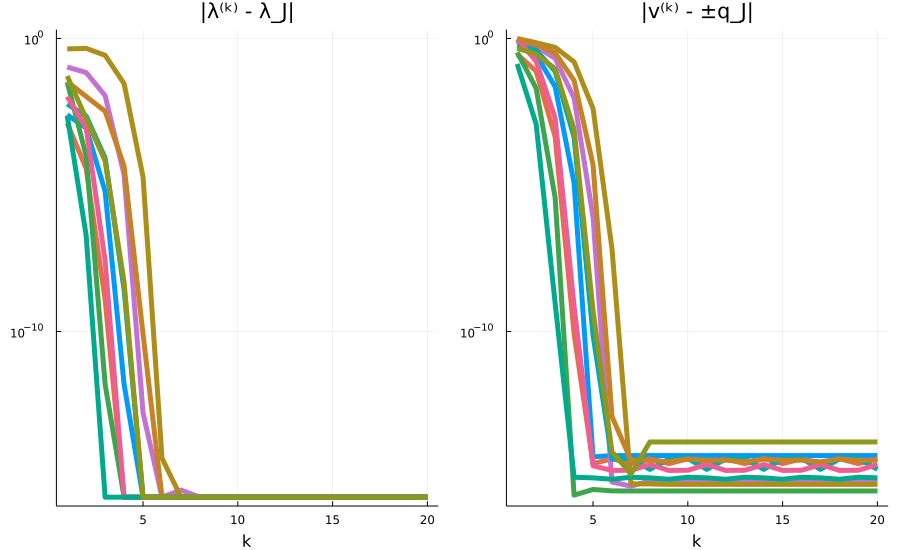

In [14]:
p = plot(xlabel="k", title="|λ⁽ᵏ⁾ - λ_J|", yscale=:log10)
q = plot(xlabel="k", title="|v⁽ᵏ⁾ - ±q_J|", yscale=:log10)
m = 10
n_iter = 20
n_test = 10
minval = 1
maxval = 1
for test in 1:n_test
    Λ = randn(m)
    Q = qr(randn(m,m)).Q
    A = Q * Diagonal(Λ) * Q'
    v⁰ = randn(m);
    data = [rayleigh_quotient_iteration(A, v⁰, i) for i in 1:n_iter]
    J = argmin(abs.(Λ .- data[end][1]))
    λs = [data[i][1] for i in 1:n_iter]
    errs = [min(norm(data[i][2] - Q[:,J]), norm(data[i][2] + Q[:,J])) for i in 1:n_iter]
    minval = min(minval, minimum(abs.(λs .- Λ[J])), minimum(errs))
    maxval = max(maxval, maximum(abs.(λs .- Λ[J])), maximum(errs))
    plot!(p, 1:n_iter, max.(eps(), abs.(λs .- Λ[J])))
    plot!(q, 1:n_iter, max.(eps(), errs))
end
minval = max(minval, eps())
plot(p, q, layout=(1,2), ylim=(0.5*minval, 2.0*maxval))

- Lines curve down $\Rightarrow$ **superlinear convergence**
- Converged to _some_ eigenvalue/eigenvector, our version is not picky

### T&B Theorem 27.3.

`rayleigh_quotient_iteration` converges to an eigenvalue/eigenvector pair for almost all $v^{(0)}$.  When it converges to $(\lambda_J, q_J)$, then

$$\|v^{(k+1)} - (\pm q_J)\| = O(\|v^{(k)} - (\pm q_J)\|^3) ,
\quad
|\lambda^{(k+1)} - \lambda_J| = O(|\lambda^{(k)} - \lambda_J|^3).$$